In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder



In [7]:
df = pd.read_csv("/before_null.csv")

In [8]:
df.isnull().sum()

Make                   0
Model                  0
Year                   0
MSRP                   0
Body Size              0
Body Style             0
Cylinders            165
Engine Aspiration      0
Drivetrain             0
Transmission           0
Horsepower             5
Torque                27
dtype: int64

In [9]:
df.corr(numeric_only=True)

,Year,MSRP,Horsepower,Torque
Year,1.000000,0.073089,0.079801,0.077029
MSRP,0.073089,1.000000,0.703264,0.621123
Horsepower,0.079801,0.703264,1.000000,0.789480
Torque,0.077029,0.621123,0.789480,1.000000


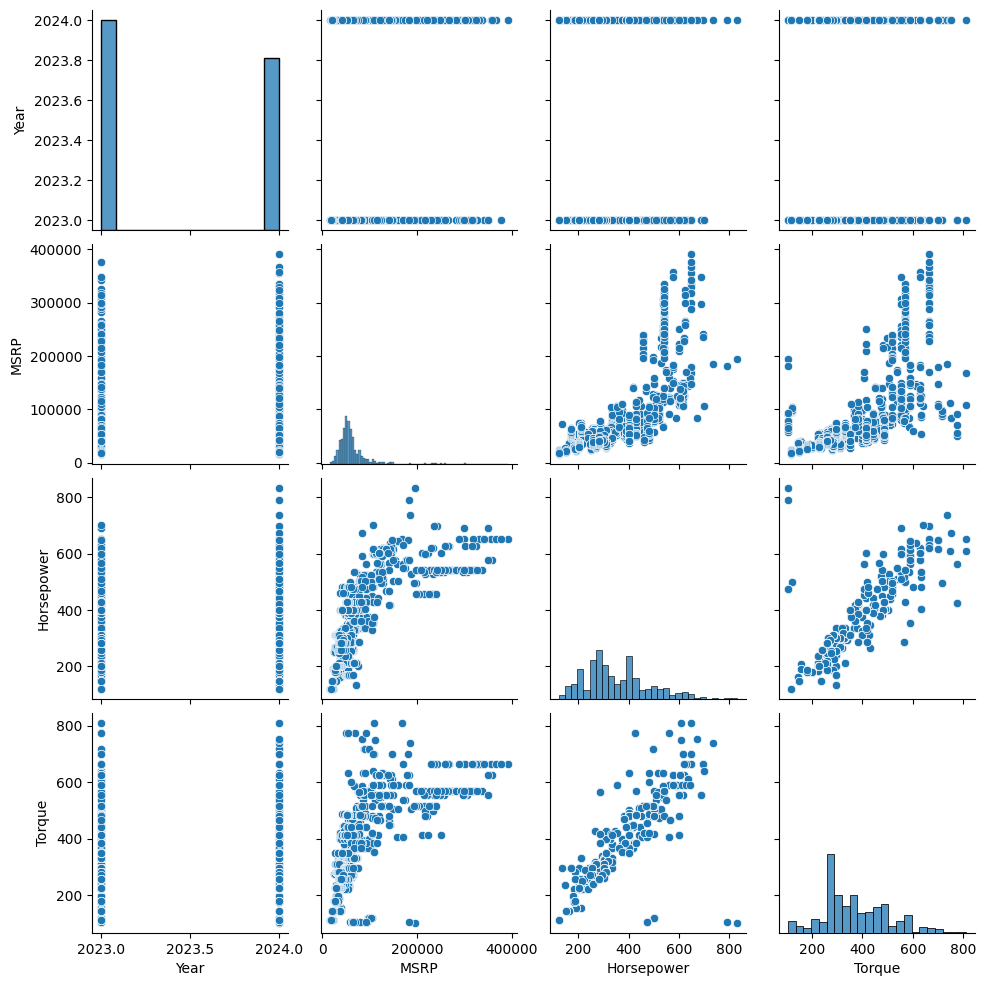

In [10]:
g = sns.pairplot(df)


There is a correlation of the variables at 0.6 and 0.7. Looking at the graph, we see that the values ​​of x are dispersed and their errors increase, which indicates heteroscedasticity.

Therefore, instead of using a linear regression model, it would be more convenient to use a Random Forest Regressor model because it handles nonlinearity and is insensitive to heteroscedasticity.

## filling in the null values ​​of troque 

In [11]:
df_not_null = df.dropna()       
df_not_null["Torque"].isnull().sum()

np.int64(0)

In [12]:
X_train = df_not_null[["MSRP", "Horsepower", "Year"]]
y_train = df_not_null["Torque"]
print(X_train.shape, y_train.shape)

(1435, 3) (1435,)


In [13]:
rfr = RandomForestRegressor() 
rfr.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
null_index = df["Torque"].isnull()  
X_test = df[null_index][["MSRP", "Horsepower", "Year"]] 
pred_null = rfr.predict(X_test)
pred_null

array([364.36, 359.88, 368.24, 364.36, 363.79, 359.88, 480.  , 480.6 ,
       477.94, 497.2 , 480.6 , 480.  , 387.12, 160.11, 158.3 , 207.75,
       155.5 , 170.75, 155.25, 381.02, 392.83, 391.83, 354.56, 354.23,
       155.5 , 155.5 , 155.5 ])

## Apply changes

In [15]:
df.loc[null_index, "Torque"] = pred_null
# Torque columns with 0 nulls
df["Torque"].isnull().sum()

np.int64(0)

## Filling null values on Cylinders

### Encoding

In [16]:
df

,Make,Model,Year,MSRP,Body Size,Body Style,Cylinders,Engine Aspiration,Drivetrain,Transmission,Horsepower,Torque
0,Aston Martin,DBX707,2024,242000.0,Large,SUV,V8,Twin-Turbo,AWD,automatic,697.0,663.0
1,Audi,A3,2024,35800.0,Compact,Sedan,I4,Turbocharged,FWD,automatic,201.0,221.0
2,Audi,A3,2024,37800.0,Compact,Sedan,I4,Turbocharged,AWD,automatic,201.0,221.0
3,Audi,A3,2024,41400.0,Compact,Sedan,I4,Turbocharged,AWD,automatic,201.0,221.0
4,Audi,A3,2024,39400.0,Compact,Sedan,I4,Turbocharged,FWD,automatic,201.0,221.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Nissan,Z,2023,50990.0,Compact,Coupe,V6,Twin-Turbo,RWD,automatic,400.0,350.0
1606,Nissan,Z,2023,53990.0,Compact,Coupe,V6,Twin-Turbo,RWD,automatic,400.0,350.0
1607,Nissan,Z,2023,53990.0,Compact,Coupe,V6,Twin-Turbo,RWD,manual,400.0,350.0
1608,Nissan,Z,2023,40990.0,Compact,Coupe,V6,Twin-Turbo,RWD,manual,400.0,350.0


In [17]:
numerical_cols = ["MSRP", "Torque", "Year", "Horsepower"]
enc_columns = ["Make", "Model", "Body Size", "Body Style", "Engine Aspiration", "Drivetrain", "Transmission"]
all_features = numerical_cols + enc_columns

In [18]:
df_not_null = df.dropna()       
df_not_null["Cylinders"].isnull().sum()

np.int64(0)

In [19]:
X_train = df_not_null[all_features]
y_train = df_not_null["Cylinders"]
print(X_train.shape, y_train.shape)

(1445, 11) (1445,)


In [20]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).set_output(transform="pandas")
ohetransform = ohe.fit_transform(X_train[enc_columns])
X_train_encoded = pd.concat([X_train[numerical_cols].reset_index(drop=True), ohetransform.reset_index(drop=True)], axis=1)
print(X_train_encoded.shape, y_train.shape)

(1445, 159) (1445,)


In [21]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

### Fit + apply changes in df

In [22]:
rfc = RandomForestClassifier()
rfc.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
null_index = df["Cylinders"].isnull()  # cogemos los datos que tienen nulos
X_test = df[null_index][all_features]

In [24]:
ohe_test = ohe.transform(X_test[enc_columns])
X_test_encoded = pd.concat([
    X_test[numerical_cols].reset_index(drop=True),
    ohe_test.reset_index(drop=True)
], axis=1)

In [25]:
predicted_labels = rfc.predict(X_test_encoded)
predicted_cylinders_real = label_encoder.inverse_transform(predicted_labels)
predicted_cylinders_real

array(['V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'I4', 'V6', 'V6', 'I4', 'V6',
       'V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'V8', 'V8',
       'V8', 'V8', 'V8', 'V6', 'V6', 'I6', 'I4', 'I4', 'I6', 'V8', 'I6',
       'V8', 'I6', 'V8', 'V8', 'V8', 'I4', 'I4', 'I4', 'I4', 'I4', 'I4',
       'I4', 'I4', 'I4', 'V6', 'V6', 'V6', 'V6', 'V6', 'V8', 'V6', 'I4',
       'I4', 'V6', 'I4', 'I4', 'V6', 'V8', 'I6', 'V6', 'I6', 'V8', 'V6',
       'I6', 'V8', 'V8', 'I6', 'I6', 'V8', 'V8', 'I6', 'V8', 'V8', 'I4',
       'I4', 'V6', 'I4', 'V6', 'V6', 'V6', 'V6', 'V6', 'V6', 'I4', 'I4',
       'I4', 'V6', 'V6', 'V6', 'I4', 'V6', 'I4', 'V6', 'V6', 'V8', 'V6',
       'V6', 'V6', 'V6', 'V6', 'V8', 'V8', 'V8', 'V8', 'V6', 'V6', 'V6',
       'I6', 'I4', 'I4', 'V8', 'V8', 'V8', 'I4', 'I4', 'I4', 'I4', 'I4',
       'I4', 'V8', 'V8', 'V8', 'V8', 'V6', 'V8', 'I4', 'V6', 'I4', 'V6',
       'I4', 'V6', 'I4', 'V6', 'I4', 'I4', 'V6', 'V8', 'V6', 'I6', 'I6',
       'V6', 'I6', 'V8', 'V8', 'I6', 'I6', 'V8', 'I

In [26]:
df.loc[null_index, "Cylinders"] = predicted_cylinders_real

In [27]:
df

,Make,Model,Year,MSRP,Body Size,Body Style,Cylinders,Engine Aspiration,Drivetrain,Transmission,Horsepower,Torque
0,Aston Martin,DBX707,2024,242000.0,Large,SUV,V8,Twin-Turbo,AWD,automatic,697.0,663.0
1,Audi,A3,2024,35800.0,Compact,Sedan,I4,Turbocharged,FWD,automatic,201.0,221.0
2,Audi,A3,2024,37800.0,Compact,Sedan,I4,Turbocharged,AWD,automatic,201.0,221.0
3,Audi,A3,2024,41400.0,Compact,Sedan,I4,Turbocharged,AWD,automatic,201.0,221.0
4,Audi,A3,2024,39400.0,Compact,Sedan,I4,Turbocharged,FWD,automatic,201.0,221.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Nissan,Z,2023,50990.0,Compact,Coupe,V6,Twin-Turbo,RWD,automatic,400.0,350.0
1606,Nissan,Z,2023,53990.0,Compact,Coupe,V6,Twin-Turbo,RWD,automatic,400.0,350.0
1607,Nissan,Z,2023,53990.0,Compact,Coupe,V6,Twin-Turbo,RWD,manual,400.0,350.0
1608,Nissan,Z,2023,40990.0,Compact,Coupe,V6,Twin-Turbo,RWD,manual,400.0,350.0


In [28]:
df.isnull().sum()

Make                 0
Model                0
Year                 0
MSRP                 0
Body Size            0
Body Style           0
Cylinders            0
Engine Aspiration    0
Drivetrain           0
Transmission         0
Horsepower           5
Torque               0
dtype: int64

## Filling nan values in hp

In [29]:
median_hp_by_make = df.groupby('Make')['Horsepower'].transform("median")
df['Horsepower'] = df['Horsepower'].fillna(median_hp_by_make)
print("Null values in HP:", df['Horsepower'].isnull().sum())

Null values in HP: 0
